In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle
from imblearn.over_sampling import ADASYN

In [2]:
#Load data
data = pd.read_csv('fakenews.csv')

In [3]:
# Count the number of rows before removing duplicates
num_rows_before = len(data)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Count the number of rows after removing duplicates
num_rows_after = len(data)

print("Number of rows before removing duplicates:", num_rows_before)
print("Number of rows after removing duplicates:", num_rows_after)

Number of rows before removing duplicates: 3206
Number of rows after removing duplicates: 3005


In [4]:
X = data['article']
y = data['label']

In [5]:
# Split the data into train (90%) and test (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Split the train set into train (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

In [6]:
# Show the number of rows for train, test, and validation sets
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 1892
Validation set size: 812
Test set size: 301


In [7]:
# Count the occurrences of each class label in train, test, and validation sets
train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

print("\nTrain set label counts:")
print(train_label_counts)
print("\nTest set label counts:")
print(test_label_counts)
print("\nValidation set label counts:")
print(val_label_counts)


Train set label counts:
label
1    950
0    942
Name: count, dtype: int64

Test set label counts:
label
1    151
0    150
Name: count, dtype: int64

Validation set label counts:
label
1    408
0    404
Name: count, dtype: int64


In [8]:
# # Text preprocessing
# def remove_diacritics(text):
#     normalized = unicodedata.normalize("NFD", text)
#     return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

# def wordopt(text):
#     text = text.lower()
#     text = remove_diacritics(text)
#     text = re.sub('\[.*?\]', '', text)
#     text = re.sub("\\W", " ", text)
#     text = re.sub('https?://\S+|www\.\S+', '', text)
#     text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('\w*\d\w*', '', text)
#     return text

# ps = PorterStemmer()
# with open('stopwords-tl.json', 'r') as f:
#     stopwords = json.load(f)

# def preprocess(text):
#     text = wordopt(text)
#     tokens = nltk.word_tokenize(text)
#     stems = [ps.stem(token) for token in tokens]
#     filtered = [stem for stem in stems if stem not in stopwords]
#     return filtered

In [10]:
# Text preprocessing
def remove_diacritics(text):
    normalized = unicodedata.normalize("NFD", text)
    return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

def wordopt(text):
    text = text.lower()
    text = remove_diacritics(text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [11]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_val = X_val.apply(preprocess)

In [12]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
X_val_tfidf = vectorizer.transform(X_val.apply(lambda x: ' '.join(x)))

In [13]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
# base_models = [('MNB', mnb), ('LR', lr), ('RF', rf), ('KNN', knn), ('SVM', svm)]

In [14]:
# Define the parameter grid
param_grid = {'penalty': ['l2'], 'C': [1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear']}

# Define the GridSearchCV
lr_grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [15]:
lr_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [16]:
print("Best parameters: ", lr_grid.best_params_)
print("Accuracy: {:.2f}%".format(lr_grid.best_score_ * 100))

Best parameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 94.82%


In [17]:
best_meta = lr_grid.best_estimator_

In [18]:
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=LogisticRegression(C=1000,
                                                      solver='liblinear'))

Metrics for MNB:
Accuracy: 0.8374384236453202
Precision: 0.7633587786259542
Recall: 0.9803921568627451
F1 Score: 0.8583690987124464
AUC: 0.9785660551349252
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81       404
           1       0.76      0.98      0.86       408

    accuracy                           0.84       812
   macro avg       0.87      0.84      0.83       812
weighted avg       0.87      0.84      0.83       812



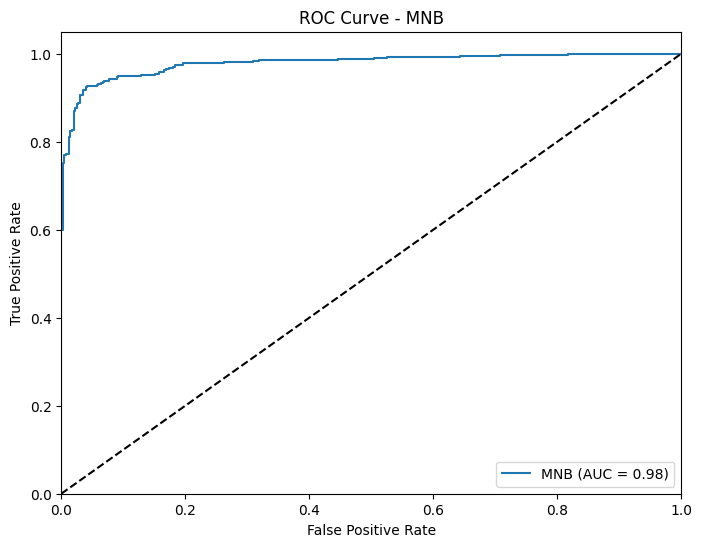

Metrics for LR:
Accuracy: 0.9322660098522167
Precision: 0.9584415584415584
Recall: 0.9044117647058824
F1 Score: 0.9306431273644389
AUC: 0.9864710735779461
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       404
           1       0.96      0.90      0.93       408

    accuracy                           0.93       812
   macro avg       0.93      0.93      0.93       812
weighted avg       0.93      0.93      0.93       812



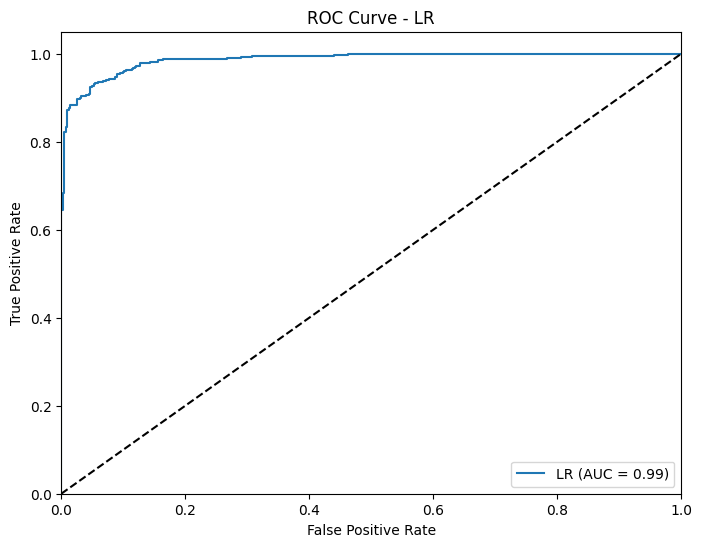

Metrics for RF:
Accuracy: 0.9310344827586207
Precision: 0.9467005076142132
Recall: 0.9142156862745098
F1 Score: 0.9301745635910225
AUC: 0.9826611337604348
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       404
           1       0.95      0.91      0.93       408

    accuracy                           0.93       812
   macro avg       0.93      0.93      0.93       812
weighted avg       0.93      0.93      0.93       812



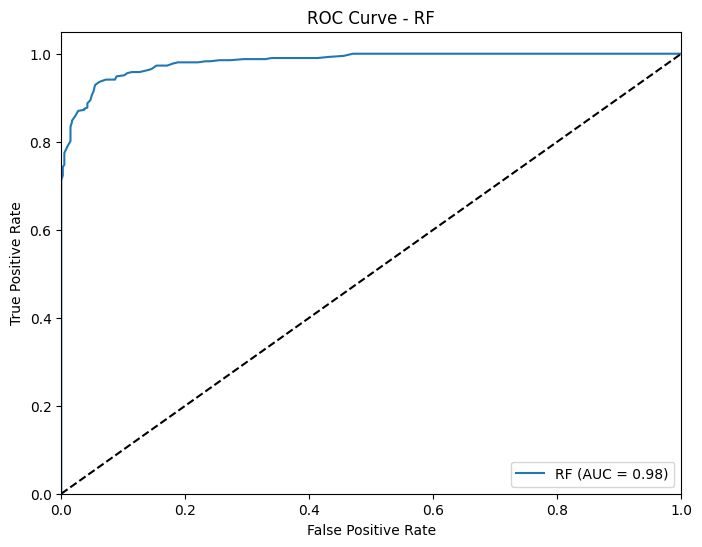

Metrics for KNN:
Accuracy: 0.8854679802955665
Precision: 0.8343949044585988
Recall: 0.9632352941176471
F1 Score: 0.89419795221843
AUC: 0.9504101145408659
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       404
           1       0.83      0.96      0.89       408

    accuracy                           0.89       812
   macro avg       0.90      0.89      0.88       812
weighted avg       0.89      0.89      0.88       812



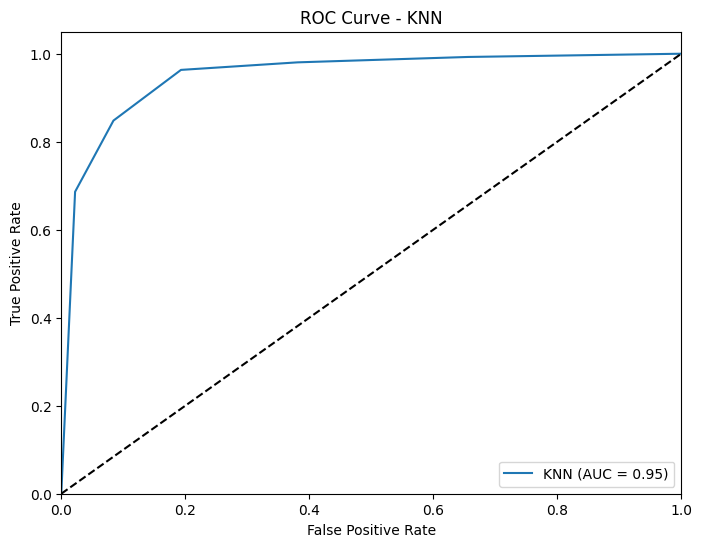

Metrics for SVM:
Accuracy: 0.9433497536945813
Precision: 0.9713541666666666
Recall: 0.9142156862745098
F1 Score: 0.9419191919191919
AUC: 0.9894316637546108
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       404
           1       0.97      0.91      0.94       408

    accuracy                           0.94       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.94      0.94      0.94       812



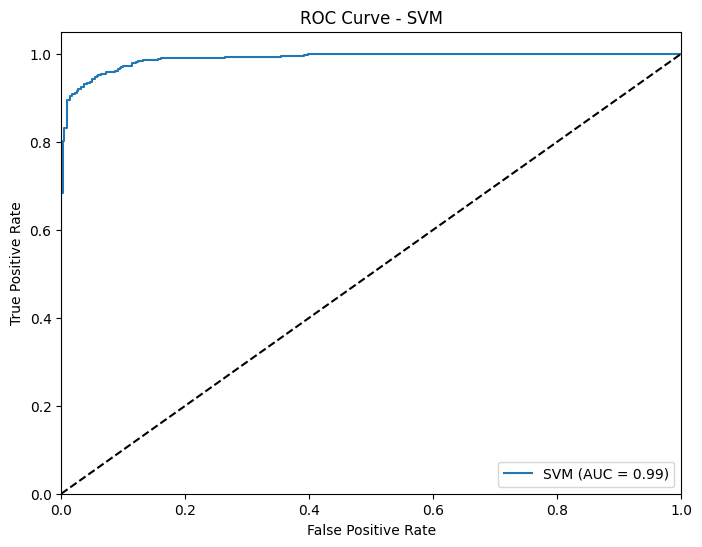

In [19]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9544334975369458
Precision: 0.9513381995133819
Recall: 0.9583333333333334
F1 Score: 0.9548229548229549
AUC: 0.9937694137060764
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       404
           1       0.95      0.96      0.95       408

    accuracy                           0.95       812
   macro avg       0.95      0.95      0.95       812
weighted avg       0.95      0.95      0.95       812



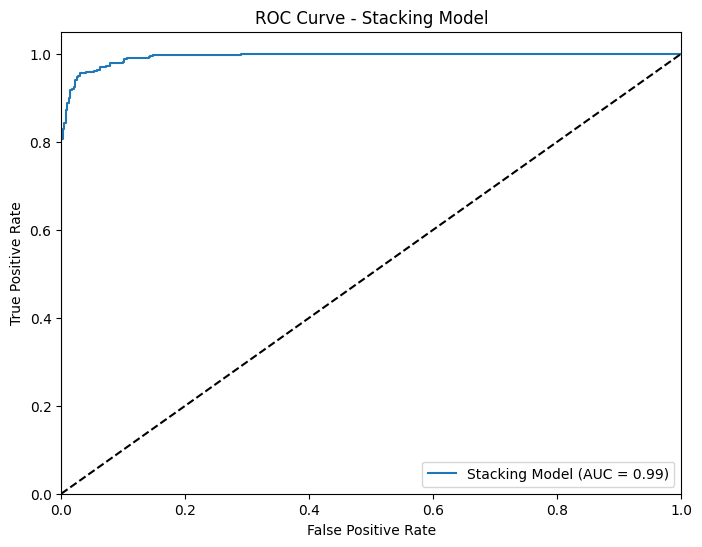

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.837438  0.763359  0.980392  0.858369  0.978566
LR              0.932266  0.958442  0.904412  0.930643  0.986471
RF              0.931034  0.946701  0.914216  0.930175  0.982661
KNN             0.885468  0.834395  0.963235  0.894198   0.95041
SVM              0.94335  0.971354  0.914216  0.941919  0.989432
Stacking Model  0.954433  0.951338  0.958333  0.954823  0.993769


In [20]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val_tfidf)
stack_y_prob = stack.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [21]:
# Save the model using joblib
joblib.dump(stack, 'stackmodel_lr_new_more.joblib')

['stackmodel_lr_new_more.joblib']